In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

def jacchia_Length(t, a1, a2, v_init, l_init):
    return l_init + v_init * t - np.abs(a1) * np.exp(np.abs(a2) * t)

def jacchia_Lag(t, a1, a2):
    return -np.abs(a1) * np.exp(np.abs(a2) * t)


def jacchia_Vel(t, a1, a2, v_init):
    return v_init - np.abs(a1) * np.abs(a2) * np.exp(np.abs(a2) * t)

def jacchia_Acc(t, a1, a2):
    return -np.abs(a1) * np.abs(a2)**2 * np.exp(np.abs(a2) * t)

def quadratic_length(t, a, b, v0, l0, t0):
    """
    Quadratic length function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # Compute the length linearly before t0
    l_before = l0 + v0*t_before

    # Compute the length quadratically after t0
    l_after = a*(t_after - t0)**3 + b*(t_after - t0)**2 + v0*(t_after - t0) + l0

    return np.concatenate((l_before, l_after))

def quadratic_lag(t, a, b, t0):
    """
    Quadratic lag function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # Compute the lag linearly before t0
    l_before = np.zeros_like(t_before)

    # Compute the lag quadratically after t0
    l_after = a*(t_after - t0)**3 + b*(t_after - t0)**2

    return np.concatenate((l_before, l_after))


def quadratic_velocity(t, a, b, v0, t0):
    """
    Quadratic velocity function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # Compute the velocity linearly before t0
    v_before = np.ones_like(t_before)*v0

    # Compute the velocity quadratically after t0
    v_after = 3*a*(t_after - t0)**2 + 2*b*(t_after - t0) + v0

    return np.concatenate((v_before, v_after))


def quadratic_acceleration(t, a, b, t0):
    """
    Quadratic acceleration function.
    """

    # Only take times <= t0
    t_before = t[t <= t0]

    # Only take times > t0
    t_after = t[t > t0]

    # No deceleration before t0
    a_before = np.zeros_like(t_before)

    # Compute the acceleration quadratically after t0
    a_after = 6*a*(t_after - t0) + 2*b

    return np.concatenate((a_before, a_after))



def length_residual(params, t_time, l_data):
    """
    Residual function for the optimization.
    """
    return np.sum((l_data - quadratic_length(t_time, *params))**2)


def lag_residual(params, t_time, l_data):
    """
    Residual function for the optimization.
    """

    return np.sum((l_data - quadratic_lag(t_time, *params))**2)




Initial guess
[-2000, -5000, 0.25]
Optimal parameters
[-4.73900960e+03  1.30676304e-05  1.06085924e-01]


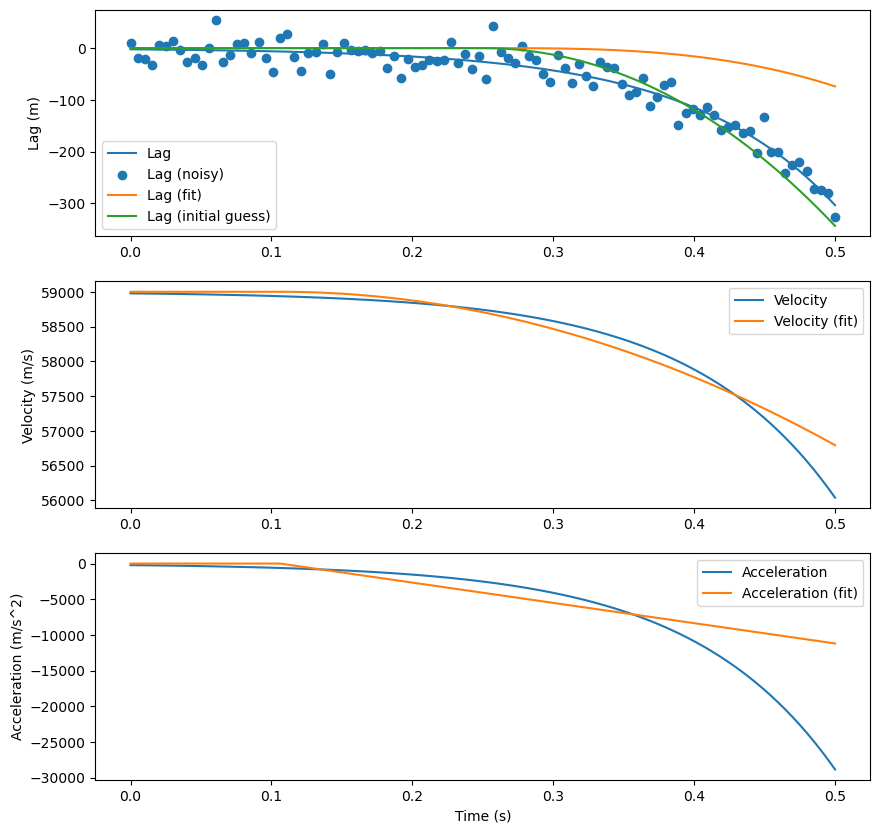

In [40]:
time_array = np.linspace(0, 0.5, 100)
l0 = 0
v0 = 59000 # m/s
a = -500
b = 50
noise_m = 20 # m

# length_array = quadratic_length(time_array, a, b, v0, l0)
# lag_array = quadratic_lag(time_array, a, b)
# velocity_array = quadratic_velocity(time_array, a, b, v0)
# acceleration_array = quadratic_acceleration(time_array, a, b)

a1=0.00464513* 500
a2=9.747014113


lag_array=jacchia_Lag(time_array, a1, a2)
length_array=jacchia_Length(time_array, a1, a2, v0, l0)
velocity_array=jacchia_Vel(time_array, a1, a2, v0)
acceleration_array=jacchia_Acc(time_array, a1, a2)

# length_array_noisy = length_array + np.random.normal(0, noise_m, len(length_array))
lag_array_noisy = lag_array + np.random.normal(0, noise_m, len(lag_array))

# use scipy minimize to find the parameters
# p0 = [-50, 1, v0, 0]
# opt_res = opt.minimize(length_residual, p0, args=(time_array, length_array_noisy), method='Nelder-Mead')
# basinhopping(residuals, initial_guess, minimizer_kwargs={"method": "L-BFGS-B"}, niter=100)
# opt_res = 
# opt.basinhopping(length_residual, p0, minimizer_kwargs={"args": (time_array, length_array_noisy), "method": "L-BFGS-B"}, niter=100)

# Set t0 to the middle of the time array
t0 = np.mean(time_array)

p0 = [-2000, -5000, t0]

print("Initial guess")
print(p0)

opt_res = opt.minimize(lag_residual, p0, args=(time_array, lag_array_noisy), method='Nelder-Mead')
#opt_res = opt.basinhopping(lag_residual, p0, minimizer_kwargs={"args": (time_array, lag_array_noisy), "method": "L-BFGS-B"}, niter=100)


print("Optimal parameters")
print(opt_res.x)

# sample the fit for the velocity and acceleration
a_fit, b_fit, t0_fit = opt_res.x
velocity_array_fit = quadratic_velocity(time_array, a_fit, b_fit, v0, t0_fit)
acceleration_array_fit = quadratic_acceleration(time_array, a_fit, b_fit, t0_fit)

# plot one on top of the other
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
# ax[0].plot(time_array, length_array, label='Length')
# ax[0].scatter(time_array, length_array_noisy, label='Length (noisy)')
ax[0].plot(time_array, lag_array, label='Lag')
ax[0].scatter(time_array, lag_array_noisy, label='Lag (noisy)')
ax[0].plot(time_array, quadratic_lag(time_array, a_fit, b_fit, t0), label='Lag (fit)')

# Plot initial guess
ax[0].plot(time_array, quadratic_lag(time_array, *p0), label='Lag (initial guess)')

ax[0].set_ylabel('Lag (m)')
ax[0].legend()
ax[1].plot(time_array, velocity_array, label='Velocity')
ax[1].plot(time_array, velocity_array_fit, label='Velocity (fit)')
ax[1].set_ylabel('Velocity (m/s)')
ax[1].legend()
ax[2].plot(time_array, acceleration_array, label='Acceleration')
ax[2].plot(time_array, acceleration_array_fit, label='Acceleration (fit)')
ax[2].set_ylabel('Acceleration (m/s^2)')
ax[2].legend()
plt.xlabel('Time (s)')
plt.show()